<a href="https://colab.research.google.com/github/srojassu/ChemicalThermodynamics/blob/main/Trabajo_final_Termoq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**TRABAJO 2 TERMODINAMICA QUÍMICA**


# Librerias

Para este algoritmo de Colab se requieren librerias. En el siguiente cuadro de codigo se importan las librerias requeridas para que el algoritmo funcione, por favor correr el cuadro antes de empezar a operar el algoritmo

In [60]:
import numpy as np
import matplotlib.pyplot as plt

# ALGORITMO DE TEMPERATURA DE BURBUJA

La metodologia propuesta en el libro de Smith Van Ness consiste en
calcular los valores de y_i y T utilizando valores de X_i y de P. La metodologia sugiere calcular la temperatura de saturación del sistema a partir de la ecuación de antoine solucionada para T. por lo tanto primero definimos todos los parametros y propiedades de la molecula

In [61]:
#se definen las constantes de Antoine
Antoine_1=np.array([16.3872, 3885.70, 230.170])  #rango de T en °C (13, 136)
Antoine_2=np.array([16.8958, 3795.17, 230.918])   #rango de T en °C (3, 96)
#se definen las propiedades criticas  para las especies puras de las moleculas
V_c1=55.9 #cm3/mol
Z_c1=0.229
T_c1=647.1 #K
P_c1=220.55 #bar
w_1= 0.345

V_c2=167 #cm3/mol
Z_c2=0.240
T_c2=513.9 #K
P_c2=61.48 #bar
w_2= 0.645
# se definenlos parametros de interacción binaria del modelo de actividad de UNIQUAC. Los cuales se obtienen a partir de los valores suministrados en el apendice G del libro de Smith Van Ness.
UNIFAC_K_H2O=17
UNIFAC_Rk_H2O=0.9200
UNIFAC_Qk_H2O=1.400
v_H2O=1

UNIFAC_K_CH3=1
UNIFAC_Rk_CH3=0.9011
UNIFAC_Qk_CH3=0.848
v_CH3=1

UNIFAC_K_CH2=2
UNIFAC_Rk_CH2=0.6744
UNIFAC_Qk_CH2=0.540
v_CH2=1

UNIFAC_K_OH=15
UNIFAC_Rk_OH=1.0000
UNIFAC_Qk_OH=1.200
V_OH=1

r_1=v_H2O*UNIFAC_Rk_H2O
q_1=v_H2O*UNIFAC_Qk_H2O

r_2=v_CH3*UNIFAC_Rk_CH3+v_CH2*UNIFAC_Rk_CH2+V_OH*UNIFAC_Rk_OH
q_2=v_CH3*UNIFAC_Qk_CH3+v_CH2*UNIFAC_Qk_CH2+V_OH*UNIFAC_Qk_OH
#se definen los parametros de interacción binaria (Uij-Ujj) Tomados del articulo de Prausnitz
u_12__u_22=378.1  #cal/mol
u_21__u_11=258.4  #cal/mol
z=10 #se define Z como 10 para el modelo de composición local
#se definen los parametros q' que evaluan los efectos de los puentes de hidrogeno entre las moleculas.
q_prima_1=1
q_prima_2=0.92

**Funciones requeridas durante el algoritmo**

Cabe resaltar la notación utilizada para los phi, Phi y PHI

phi --> parametros para las fugacidades

Phi --> Parametro para la ecuación de UNIQUAC

PHI --> Parametro para el coef. de fugacidad del metodo PHI-GAMMA

In [62]:
#Definimos Func_Tsat como la ecuacion de antoine resuelta para T
def Func_Tsat(P, A_i, B_i, C_i):
   return (B_i/(A_i-np.log(P)))-C_i
#Definimos Func_Psat como la ecuación de antoine resuelta para P
def Func_Psat(T, A_i, B_i, C_i):
   return np.exp(A_i-(B_i/(T+C_i)))
#Definimos las ecuaciones a utilizar para el modelo de UNIQUAC
def Func_l_i(z, r_i, q_i):
  return (z/2)*(r_i-q_i)-(r_i-1)
def Func_Phi_i(r_i, r_j, X_i, X_j):
  return (X_i*r_i)/(X_i*r_i+X_j*r_j)
def Func_theta_i(q_i, q_j, X_i, X_j):
  return (X_i*q_i)/(X_i*q_i+X_j*q_j)
def Func_theta_prima_i(q_prima_i, q_prima_j, X_i, X_j):
  return (X_i*q_prima_i)/(X_i*q_prima_i+X_j*q_prima_j)
def Func_tau_ij(u_ij__u_jj,R,T):
  return np.exp((-(u_ij__u_jj))/(R*(T+273.15)))
def Func_gamma_i(Phi_i, X_i, Z, q_i, theta_i, Phi_j, l_i, r_i, r_j, l_j, q_prima_i, theta_prima_i,theta_prima_j, tau_ji, tau_ij):
  return np.exp((np.log(Phi_i/X_i))+((Z/2)*q_i*np.log(theta_i/Phi_i))+(Phi_j*(l_i-(r_i/r_j)*l_j))-(q_prima_i*np.log(theta_prima_i+theta_prima_j*tau_ji))+(theta_prima_j*q_prima_i*((tau_ji/(theta_prima_i+theta_prima_j*tau_ji))-(tau_ij/(theta_prima_j+theta_prima_i*tau_ij)))))
#Se define la expresión para la presion de saturación de la forma 1
def Func_Psat_forma1_i(P, X_i, gamma_i, PHI_i, X_j, gamma_j, PHI_j, Psat_i, Psat_j):
  return P/((((X_i* gamma_i)/ PHI_i)+(((X_j*gamma_j)/PHI_j)*(Psat_j/Psat_i))))
  #Se define la expresión para la presion de saturación de la forma 2
def Func_Psat_forma2_i(P,Y_i, PHI_i, gamma_i,Y_j, PHI_j, gamma_j, Psat_i, Psat_j):
    return P*(((Y_j*PHI_j)/gamma_j)+(((Y_i*PHI_i)/gamma_i)*(Psat_j/Psat_i)))
#Se define una expresión para el coeficiente de reparto
def Func_K_i(gamma_i, P, Psat_i, PHI_i):
  return (gamma_i*Psat_i)/(P*PHI_i)
#Se define una expresión para la presión de burbuja
def Func_P_burb(X_i, gamma_i, Psat_i, PHI_i, X_j, gamma_j, Psat_j, PHI_j):
  return ((X_i*gamma_i*Psat_i)/PHI_i)+((X_j*gamma_j*Psat_j)/PHI_j)
  #Se define una expresión para la presión de rocio
def Func_P_rocio(Y_i, PHI_i, Psat_i,  gamma_i, Y_j, PHI_j, Psat_j,  gamma_j):
  return 1/(((Y_i*PHI_i)/(gamma_i*Psat_i))+((Y_j*PHI_j)/(gamma_j*Psat_j)))
#Se definen las expresiones para la correlación de Tsonopolus para el segundo coeficiente virial con el fin de determinar el coeficiente de fugacidad
def Func_B0_i(T_ri):
  return 0.1445-(0.330/(T_ri))-(0.1385/(T_ri**(2)))-(0.0121/(T_ri**(3)))-(0.000607/(T_ri**(8)))
def Func_B1_i(T_ri):
    return 0.0637+(0.331/(T_ri**(2)))-(0.423/(T_ri**(3)))-(0.008/(T_ri**(8)))
def Func_PHI_i_v(B0_i, w_i, B1_i, P_ri, T_ri):
    return np.exp((B0_i+w_i*B1_i)*(P_ri/T_ri))
def Func_PHIsat_i(B0_i, w_i, B1_i, Psat_i, P_ci, T_ri):
    return np.exp((B0_i+w_i*B1_i)*((Psat_i/P_ci)/T_ri))
def Func_PHI_i(PHI_i_vap, PHIsat_i):
    return (PHI_i_vap/PHIsat_i)

#Se definen las expresiones para el calculo de PHI
def func_PHI(VL_i, P, Psat_i, R, T, phi_i, phi_i_sat):
    return (phi_i/phi_i_sat)*np.exp(-(VL_i*(P-Psat_i))/(R*T))

In [63]:
P=100 # kPa
X_1=0.6 #Aqui escriba el valor de composición al que desea evaluar la temperatura de burbuja
X_2=1-X_1
R=1.9872
PHI_1=1
PHI_2=1
Z=10
#DEFINIMOS PHI y gamma DEL METODO PHI-GAMMA unitarios
PHI_1=1
PHI_2=1
gamma_1=1
gamma_2=1
#Se calculan las temperaturas de saturación
Tsat_1=Func_Tsat(P, Antoine_1[0], Antoine_1[1], Antoine_1[2])
Tsat_2=Func_Tsat(P, Antoine_2[0], Antoine_2[1], Antoine_2[2])
#Para un primer valor de T se evalua un T_0
T_0=(Tsat_1*X_1+Tsat_2*X_2)
#defino valores para el error
re=np.inf
error=0.00001
while abs(re) > error:
  #con esta Temperatura inicial calculo presiones de saturación utilizando Antoine
  Psat_1=Func_Psat(T_0, Antoine_1[0], Antoine_1[1], Antoine_1[2])
  Psat_2=Func_Psat(T_0, Antoine_2[0], Antoine_2[1], Antoine_2[2])
  #Evaluo coeficientes de actividad utilizando UNIQUAC
  l_1= Func_l_i(z, r_1, q_1)
  l_2= Func_l_i(z, r_2, q_2)
  Phi_1= Func_Phi_i(r_1, r_2, X_1, X_2)
  Phi_2= Func_Phi_i(r_2, r_1, X_2, X_1)
  theta_1= Func_theta_i(q_1, q_2, X_1, X_2)
  theta_2= Func_theta_i(q_2, q_1, X_2, X_1)
  theta_prima_1=Func_theta_prima_i(q_prima_1, q_prima_2, X_1, X_2)
  theta_prima_2=Func_theta_prima_i(q_prima_2, q_prima_1, X_2, X_1)
  tau_12=Func_tau_ij(u_12__u_22,R,T_0)
  tau_21=Func_tau_ij(u_21__u_11,R,T_0)
  gamma_1_calc= Func_gamma_i(Phi_1, X_1, Z, q_1, theta_1, Phi_2, l_1, r_1, r_2, l_2, q_prima_1, theta_prima_1,theta_prima_2, tau_21, tau_12)
  gamma_2_calc= Func_gamma_i(Phi_2, X_2, Z, q_2, theta_2, Phi_1, l_2, r_2, r_1, l_1, q_prima_2, theta_prima_2,theta_prima_1, tau_12, tau_21)
  #Mediante los coeficiente de actividad calculados evaluo Psat_2 de la forma 1
  Psat_forma1_2=Func_Psat_forma1_i(P, X_2, gamma_2_calc, PHI_2, X_1, gamma_1_calc, PHI_1, Psat_2, Psat_1)
  #Utilizo esta Presion para calcular una temperatura mediante antoine
  T_calc_using_j=Func_Tsat(Psat_forma1_2, Antoine_2[0], Antoine_2[1], Antoine_2[2])
  #Utilizo esta temperatura como un primer valor para T y mediante este valor evaluo Psat
  Psat_1=Func_Psat(T_calc_using_j, Antoine_1[0], Antoine_1[1], Antoine_1[2])
  Psat_2=Func_Psat(T_calc_using_j, Antoine_2[0], Antoine_2[1], Antoine_2[2])
  #se evaluan temperatura reducida y presión reducida
  T_r1=(T_calc_using_j+273.15)/T_c1
  T_r2=(T_calc_using_j+273.15)/T_c2
  P_r1=P/(P_c1*100)
  P_r2=P/(P_c2*100)
  #Evaluamos B0 y B1
  B0_1=Func_B0_i(T_r1)
  B0_2=Func_B0_i(T_r2)
  B1_1=Func_B1_i(T_r1)
  B1_2=Func_B1_i(T_r2)
  #Evaluamos phi
  phi_1=Func_PHI_i_v(B0_1, w_1, B1_1, P_r1, T_r1)
  phi_2=Func_PHI_i_v(B0_2, w_2, B1_2, P_r2, T_r2)
  #Evaluamos phi_sat
  phi_sat_1=Func_PHIsat_i(B0_1, w_1, B1_1, Psat_1, P_c1, T_r1)
  phi_sat_2=Func_PHIsat_i(B0_2, w_2, B1_2, Psat_2, P_c2, T_r2)
  #Determinamos PHI
  PHI_1_calc=Func_PHI_i(phi_1, phi_sat_1)
  PHI_2_calc=Func_PHI_i(phi_2, phi_sat_2)
  #Se evalua Psat_2 de la forma 1
  Psat_forma1_2=Func_Psat_forma1_i(P, X_2, gamma_2, PHI_2, X_1, gamma_1, PHI_1, Psat_2, Psat_1)
  #Se evalua la T a comparar
  T_calc=Func_Tsat(Psat_forma1_2, Antoine_2[0], Antoine_2[1], Antoine_2[2])
  re=(T_calc-T_0)

  print(T_0)
  T_0=T_calc
  print(T_0)

#Se evalua el coef. de reparto
K_1=Func_K_i(gamma_1, P, Psat_1, PHI_1)
K_2=Func_K_i(gamma_2, P, Psat_2, PHI_2)
#Evaluamos Y_i
Y_1=X_1*K_1
Y_2=X_2*K_2

90.92437216540289
88.58833612207263
88.58833612207263
88.58842293428148
88.58842293428148
88.58842293104914


Ahora para la grafica

In [64]:
P=100*(np.ones(101)) # kPa
X_1=np.linspace(0, 1, 101) #Aqui escriba el valor de composición al que desea evaluar la temperatura de burbuja
X_2=np.ones(101)-np.linspace(0, 1, 101)
R=1.9872
PHI_1=1
PHI_2=1
Z=10
#DEFINIMOS PHI y gamma DEL METODO PHI-GAMMA unitarios
PHI_1=1
PHI_2=1
gamma_1=1
gamma_2=1
#Se calculan las temperaturas de saturación
Tsat_1=Func_Tsat(P, Antoine_1[0], Antoine_1[1], Antoine_1[2])
Tsat_2=Func_Tsat(P, Antoine_2[0], Antoine_2[1], Antoine_2[2])
#Para un primer valor de T se evalua un T_0
T_0=(Tsat_1*X_1+Tsat_2*X_2)
#defino valores para el error
re=np.inf*np.ones(101)
error=0.00001
while abs(re).all() > error:
  #con esta Temperatura inicial calculo presiones de saturación utilizando Antoine
  Psat_1=Func_Psat(T_0, Antoine_1[0], Antoine_1[1], Antoine_1[2])
  Psat_2=Func_Psat(T_0, Antoine_2[0], Antoine_2[1], Antoine_2[2])
  #Evaluo coeficientes de actividad utilizando UNIQUAC
  l_1= Func_l_i(z, r_1, q_1)
  l_2= Func_l_i(z, r_2, q_2)
  Phi_1= Func_Phi_i(r_1, r_2, X_1, X_2)
  Phi_2= Func_Phi_i(r_2, r_1, X_2, X_1)
  theta_1= Func_theta_i(q_1, q_2, X_1, X_2)
  theta_2= Func_theta_i(q_2, q_1, X_2, X_1)
  theta_prima_1=Func_theta_prima_i(q_prima_1, q_prima_2, X_1, X_2)
  theta_prima_2=Func_theta_prima_i(q_prima_2, q_prima_1, X_2, X_1)
  tau_12=Func_tau_ij(u_12__u_22,R,T_0)
  tau_21=Func_tau_ij(u_21__u_11,R,T_0)
  gamma_1_calc= Func_gamma_i(Phi_1, X_1, Z, q_1, theta_1, Phi_2, l_1, r_1, r_2, l_2, q_prima_1, theta_prima_1,theta_prima_2, tau_21, tau_12)
  gamma_2_calc= Func_gamma_i(Phi_2, X_2, Z, q_2, theta_2, Phi_1, l_2, r_2, r_1, l_1, q_prima_2, theta_prima_2,theta_prima_1, tau_12, tau_21)
  #Mediante los coeficiente de actividad calculados evaluo Psat_2 de la forma 1
  Psat_forma1_2=Func_Psat_forma1_i(P, X_2, gamma_2_calc, PHI_2, X_1, gamma_1_calc, PHI_1, Psat_2, Psat_1)
  #Utilizo esta Presion para calcular una temperatura mediante antoine
  T_calc_using_j=Func_Tsat(Psat_forma1_2, Antoine_2[0], Antoine_2[1], Antoine_2[2])
  #Utilizo esta temperatura como un primer valor para T y mediante este valor evaluo Psat
  Psat_1=Func_Psat(T_calc_using_j, Antoine_1[0], Antoine_1[1], Antoine_1[2])
  Psat_2=Func_Psat(T_calc_using_j, Antoine_2[0], Antoine_2[1], Antoine_2[2])
  #se evaluan temperatura reducida y presión reducida
  T_r1=(T_calc_using_j+273.15)/T_c1
  T_r2=(T_calc_using_j+273.15)/T_c2
  P_r1=P/(P_c1*100)
  P_r2=P/(P_c2*100)
  #Evaluo ecuacion de Rackett
  #V_s_1=Func_V_s_i(V_c1, Z_c1, T_r1)
  #V_s_2=Func_V_s_i(V_c2, Z_c2, T_r2)
  #Evaluamos B0 y B1
  B0_1=Func_B0_i(T_r1)
  B0_2=Func_B0_i(T_r2)
  B1_1=Func_B1_i(T_r1)
  B1_2=Func_B1_i(T_r2)
  #Evaluamos phi
  phi_1=Func_PHI_i_v(B0_1, w_1, B1_1, P_r1, T_r1)
  phi_2=Func_PHI_i_v(B0_2, w_2, B1_2, P_r2, T_r2)
  #Evaluamos phi_sat
  phi_sat_1=Func_PHIsat_i(B0_1, w_1, B1_1, Psat_1, P_c1, T_r1)
  phi_sat_2=Func_PHIsat_i(B0_2, w_2, B1_2, Psat_2, P_c2, T_r2)
  #Determinamos PHI
  PHI_1_calc=Func_PHI_i(phi_1, phi_sat_1)
  PHI_2_calc=Func_PHI_i(phi_2, phi_sat_2)
  #Se evalua Psat_2 de la forma 1
  Psat_forma1_2=Func_Psat_forma1_i(P, X_2, gamma_2, PHI_2, X_1, gamma_1, PHI_1, Psat_2, Psat_1)
  #Se evalua la T a comparar
  T_calc=Func_Tsat(Psat_forma1_2, Antoine_2[0], Antoine_2[1], Antoine_2[2])
  re=(T_calc-T_0)


  T_0=T_calc


#Se evalua el coef. de reparto
K_1=Func_K_i(gamma_1, P, Psat_1, PHI_1)
K_2=Func_K_i(gamma_2, P, Psat_2, PHI_2)
#Evaluamos Y_i
Y_1=X_1*K_1
Y_2=X_2*K_2

Tburbuja=T_calc
print(Tburbuja)

[        nan 78.01005247 78.15341301 78.29773222 78.44302043 78.58928829
 78.73654672 78.88480693 79.03408044 79.18437903 79.33571478 79.48810007
 79.64154755 79.79607019 79.95168122 80.10839419 80.26622295 80.42518165
 80.58528473 80.74654697 80.90898346 81.07260958 81.23744108 81.403494
 81.57078476 81.73933007 81.90914705 82.08025311 82.25266608 82.42640412
 82.60148579 82.77793002 82.95575613 83.13498385 83.31563331 83.49772506
 83.68128007 83.86631975 84.05286595 84.24094096 84.43056755 84.62176894
 84.81456884 85.00899144 85.20506142 85.402804   85.60224487 85.80341027
 86.00632695 86.21102224 86.41752396 86.62586053 86.8360609  87.0481546
 87.26217171 87.47814291 87.69609942 87.91607303 88.13809612 88.3622016
 88.58842293 88.81679412 89.04734968 89.2801246  89.51515434 89.75247477
 89.99212213 90.23413296 90.47854405 90.72539231 90.97471472 91.22654814
 91.48092921 91.7378941  91.99747838 92.25971664 92.52464226 92.79228696
 93.06268037 93.33584945 93.6118178  93.89060484 94.172

<ipython-input-62-c139cd51cd08>:19: RuntimeWarning: invalid value encountered in divide
  return np.exp((np.log(Phi_i/X_i))+((Z/2)*q_i*np.log(theta_i/Phi_i))+(Phi_j*(l_i-(r_i/r_j)*l_j))-(q_prima_i*np.log(theta_prima_i+theta_prima_j*tau_ji))+(theta_prima_j*q_prima_i*((tau_ji/(theta_prima_i+theta_prima_j*tau_ji))-(tau_ij/(theta_prima_j+theta_prima_i*tau_ij)))))


[77.65 77.75 77.95 78.25 78.55 78.85 79.15 79.75 79.85 80.05 80.85 81.45
 81.45 81.55 82.55 82.85 88.85 92.75 94.15 95.35 95.55]
[77.85 77.95 77.95 77.95 78.55 78.65 78.85 79.15 79.45 80.05 80.45 80.95
 81.35 81.55 82.25 82.45 83.55 85.35 88.45 95.45 96.75 97.95 99.45]


Text(0.5, 1.0, 'Diagrama de equilibrio Txy')

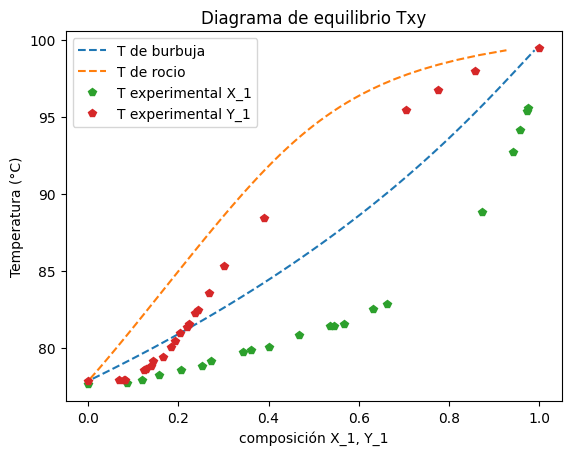

In [65]:
X_1_exp=[0, 0.0862, 0.1198, 0.1568, 0.2054, 0.2528, 0.2726, 0.3428, 0.362, 0.4007, 0.4667, 0.5353, 0.5455, 0.5675, 0.632, 0.6623, 0.873, 0.941, 0.958, 0.9724, 0.9747]
T_X_1_exp_K=[350.8, 350.9, 351.1, 351.4, 351.7, 352, 352.3, 352.9, 353, 353.2, 354, 354.6, 354.6, 354.7, 355.7, 356, 362, 365.9, 367.3, 368.5, 368.7]
T_X_1_exp_Celcius=T_X_1_exp_K-(np.ones(21)*273.15)
print(T_X_1_exp_Celcius)
Y_1_exp=[0, 0.0679, 0.08, 0.081, 0.1239, 0.128, 0.1384, 0.1431, 0.1666, 0.1846, 0.1926, 0.2037, 0.22, 0.2228, 0.236, 0.2432, 0.2682, 0.3012, 0.39, 0.7041, 0.7758, 0.8579, 1]
T_Y_1_exp_K=[351, 351.1, 351.1, 351.1, 351.7, 351.8, 352, 352.3, 352.6, 353.2, 353.6, 354.1, 354.5, 354.7, 355.4, 355.6, 356.7, 358.5, 361.6, 368.6, 369.9, 371.1, 372.6]
T_Y_1_exp_Celcius=T_Y_1_exp_K-(np.ones(23)*273.15)
print(T_Y_1_exp_Celcius)


plt.plot(X_1,Tburbuja,'--')
plt.plot(Y_1,Tburbuja,'--')
plt.plot(X_1_exp, T_X_1_exp_Celcius, "p")
plt.plot(Y_1_exp, T_Y_1_exp_Celcius, "p")
plt.xlabel('composición X_1, Y_1')
plt.ylabel('Temperatura (°C)')
plt.legend(['T de burbuja', 'T de rocio', 'T experimental X_1', 'T experimental Y_1']);
plt.title('Diagrama de equilibrio Txy')


In [66]:
Antoine_1=np.array([16.3872, 3885.70, 230.170])  #rango de T en °C (13, 136)
Antoine_2=np.array([16.8958, 3795.17, 230.918])   #rango de T en °C (3, 96)
T_agua_puro_rocio=Func_Tsat(P, Antoine_1[0], Antoine_1[1], Antoine_1[2])
T_etanol_puro_rocio=Func_Tsat(P, Antoine_2[0], Antoine_2[1], Antoine_2[2])
print(T_agua_puro_rocio)
print(T_etanol_puro_rocio)
#Trocio[0]=T_etanol_puro_rocio
#Trocio[100]=T_agua_puro_rocio
#Tburbuja[0]=T_etanol_puro_rocio
#Tburbuja[100]=T_agua_puro_rocio

[99.6288599 99.6288599 99.6288599 99.6288599 99.6288599 99.6288599
 99.6288599 99.6288599 99.6288599 99.6288599 99.6288599 99.6288599
 99.6288599 99.6288599 99.6288599 99.6288599 99.6288599 99.6288599
 99.6288599 99.6288599 99.6288599 99.6288599 99.6288599 99.6288599
 99.6288599 99.6288599 99.6288599 99.6288599 99.6288599 99.6288599
 99.6288599 99.6288599 99.6288599 99.6288599 99.6288599 99.6288599
 99.6288599 99.6288599 99.6288599 99.6288599 99.6288599 99.6288599
 99.6288599 99.6288599 99.6288599 99.6288599 99.6288599 99.6288599
 99.6288599 99.6288599 99.6288599 99.6288599 99.6288599 99.6288599
 99.6288599 99.6288599 99.6288599 99.6288599 99.6288599 99.6288599
 99.6288599 99.6288599 99.6288599 99.6288599 99.6288599 99.6288599
 99.6288599 99.6288599 99.6288599 99.6288599 99.6288599 99.6288599
 99.6288599 99.6288599 99.6288599 99.6288599 99.6288599 99.6288599
 99.6288599 99.6288599 99.6288599 99.6288599 99.6288599 99.6288599
 99.6288599 99.6288599 99.6288599 99.6288599 99.6288599 99.628

In [67]:
from ast import While
def Psat_calc_i(P, X_i, gamma_i, PHI_i, X_j, gamma_j, PHI_j, Psat_i, Psat_j):
  return P/(((X_i* gamma_i)/ PHI_i)+(((X_j*gamma_j)/PHI_j)*(Psat_j/Psat_i)))

P=100*(np.ones(101)) # kPa
X_1=0.999 #Aqui escriba el valor de composición al que desea evaluar la temperatura de burbuja
X_2=1-X_1
VectorX_1=np.linspace(0, 1, 101) #NO EDITAR ESTA LINEA DE CODIGO
VectorX_2=np.ones(101)-np.linspace(0, 1, 101)
R=1.9872
Z=10

#DEFINIMOS PHI y gamma DEL METODO PHI-GAMMA
PHI_1=1
PHI_2=1
gamma_1=1
gamma_2=1


Tsat_1=Func_Tsat(P, Antoine_1[0], Antoine_1[1], Antoine_1[2])
Tsat_2=Func_Tsat(P, Antoine_2[0], Antoine_2[1], Antoine_2[2])

T_0=(Tsat_1*VectorX_1+Tsat_2*X_2)
T= T_0

#Comenzamos el bucle
Error=0.0001
re=np.inf
esperado=1
Resultado=[]


while abs(re) > Error:

  Psat_1=Func_Psat(T, Antoine_1[0], Antoine_1[1], Antoine_1[2])
  Psat_2=Func_Psat(T, Antoine_2[0], Antoine_2[1], Antoine_2[2])

  l_1= Func_l_i(z, r_1, q_1)
  l_2= Func_l_i(z, r_2, q_2)

  Phi_1= Func_Phi_i(r_1, r_2, VectorX_1, VectorX_2)
  Phi_2= Func_Phi_i(r_2, r_1, VectorX_2, VectorX_1)

  theta_1= Func_theta_i(q_1, q_2, VectorX_1, VectorX_2)
  theta_2= Func_theta_i(q_2, q_1, VectorX_2, VectorX_1)

  theta_prima_1=Func_theta_prima_i(q_prima_1, q_prima_2, VectorX_1, VectorX_2)
  theta_prima_2=Func_theta_prima_i(q_prima_2, q_prima_1, VectorX_2, VectorX_1)

  tau_12=Func_tau_ij(u_12__u_22,R,T)
  tau_21=Func_tau_ij(u_21__u_11,R,T)

  gamma_1= Func_gamma_i(Phi_1, VectorX_1, Z, q_1, theta_1, Phi_2, l_1, r_1, r_2, l_2, q_prima_1, theta_prima_1,theta_prima_2, tau_21, tau_12)
  gamma_2= Func_gamma_i(Phi_2, VectorX_2, Z, q_2, theta_2, Phi_1, l_2, r_2, r_1, l_1, q_prima_2, theta_prima_2,theta_prima_1, tau_12, tau_21)

  Psat_1_calc=Psat_calc_i(P, VectorX_1, gamma_1, PHI_1, VectorX_2, gamma_2, PHI_1, Psat_1, Psat_2)
  Psat_2_calc=Psat_calc_i(P, VectorX_2, gamma_2, PHI_2, VectorX_1, gamma_1, PHI_2, Psat_2, Psat_1)

  T_calc_using_j=Func_Tsat(Psat_2_calc, Antoine_2[0], Antoine_2[1], Antoine_2[2])

  valor_esperado=T

  re=sum(T_calc_using_j-T)
  T=T_calc_using_j
  print(T)
  Tburbuja=T

[        nan 77.82699695 77.79370557 77.76721583 77.74702994 77.73269726
 77.72380928 77.7199953  77.72091855 77.7262729  77.73577984 77.74918586
 77.76626017 77.78679261 77.81059182 77.83748364 77.86730961 77.89992571
 77.93520118 77.97301751 78.01326745 78.05585427 78.10069092 78.14769941
 78.19681022 78.24796174 78.30109979 78.35617721 78.41315347 78.47199434
 78.53267159 78.59516273 78.65945079 78.72552412 78.79337624 78.8630057
 78.934416   79.00761546 79.08261723 79.15943924 79.23810419 79.31863961
 79.4010779  79.48545642 79.5718176  79.66020907 79.75068388 79.84330068
 79.93812396 80.03522436 80.13467899 80.23657181 80.34099407 80.44804479
 80.55783131 80.67046994 80.78608663 80.9048178  81.02681121 81.15222702
 81.28123886 81.4140352  81.55082077 81.69181822 81.83727002 81.98744058
 82.14261867 82.30312024 82.46929153 82.64151279 82.82020235 83.00582155
 83.19888022 83.39994316 83.60963765 83.82866218 84.0577967  84.29791467
 84.54999728 84.81515032 85.09462422 85.38983815 85.

<ipython-input-62-c139cd51cd08>:19: RuntimeWarning: invalid value encountered in divide
  return np.exp((np.log(Phi_i/X_i))+((Z/2)*q_i*np.log(theta_i/Phi_i))+(Phi_j*(l_i-(r_i/r_j)*l_j))-(q_prima_i*np.log(theta_prima_i+theta_prima_j*tau_ji))+(theta_prima_j*q_prima_i*((tau_ji/(theta_prima_i+theta_prima_j*tau_ji))-(tau_ij/(theta_prima_j+theta_prima_i*tau_ij)))))


In [68]:
Antoine_1=np.array([16.3872, 3885.70, 230.170])  #rango de T en °C (13, 136)
Antoine_2=np.array([16.8958, 3795.17, 230.918])   #rango de T en °C (3, 96)
T_agua_puro_rocio=Func_Tsat(P, Antoine_1[0], Antoine_1[1], Antoine_1[2])
T_etanol_puro_rocio=Func_Tsat(P, Antoine_2[0], Antoine_2[1], Antoine_2[2])


Tburbuja[0]=77.8676405595524
Tburbuja[100]=99.62885990263655

[77.65 77.75 77.95 78.25 78.55 78.85 79.15 79.75 79.85 80.05 80.85 81.45
 81.45 81.55 82.55 82.85 88.85 92.75 94.15 95.35 95.55]
[77.85 77.95 77.95 77.95 78.55 78.65 78.85 79.15 79.45 80.05 80.45 80.95
 81.35 81.55 82.25 82.45 83.55 85.35 88.45 95.45 96.75 97.95 99.45]


Text(0.5, 1.0, 'Diagrama de equilibrio Txy')

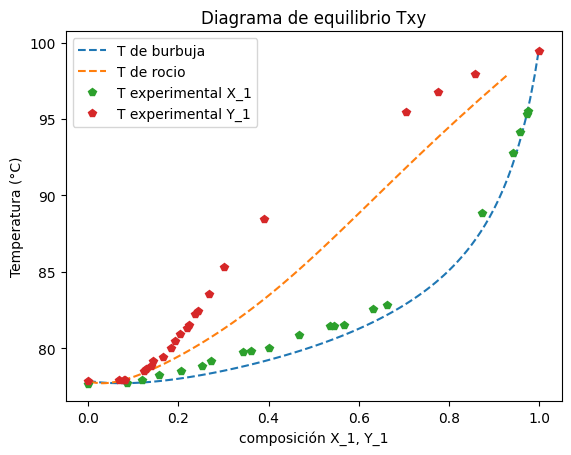

In [69]:
X_1_exp=[0, 0.0862, 0.1198, 0.1568, 0.2054, 0.2528, 0.2726, 0.3428, 0.362, 0.4007, 0.4667, 0.5353, 0.5455, 0.5675, 0.632, 0.6623, 0.873, 0.941, 0.958, 0.9724, 0.9747]
T_X_1_exp_K=[350.8, 350.9, 351.1, 351.4, 351.7, 352, 352.3, 352.9, 353, 353.2, 354, 354.6, 354.6, 354.7, 355.7, 356, 362, 365.9, 367.3, 368.5, 368.7]
T_X_1_exp_Celcius=T_X_1_exp_K-(np.ones(21)*273.15)
print(T_X_1_exp_Celcius)
Y_1_exp=[0, 0.0679, 0.08, 0.081, 0.1239, 0.128, 0.1384, 0.1431, 0.1666, 0.1846, 0.1926, 0.2037, 0.22, 0.2228, 0.236, 0.2432, 0.2682, 0.3012, 0.39, 0.7041, 0.7758, 0.8579, 1]
T_Y_1_exp_K=[351, 351.1, 351.1, 351.1, 351.7, 351.8, 352, 352.3, 352.6, 353.2, 353.6, 354.1, 354.5, 354.7, 355.4, 355.6, 356.7, 358.5, 361.6, 368.6, 369.9, 371.1, 372.6]
T_Y_1_exp_Celcius=T_Y_1_exp_K-(np.ones(23)*273.15)
print(T_Y_1_exp_Celcius)


plt.plot(VectorX_1,Tburbuja,'--')
plt.plot(Y_1,Tburbuja,'--')
plt.plot(X_1_exp, T_X_1_exp_Celcius, "p")
plt.plot(Y_1_exp, T_Y_1_exp_Celcius, "p")
plt.xlabel('composición X_1, Y_1')
plt.ylabel('Temperatura (°C)')
plt.legend(['T de burbuja', 'T de rocio', 'T experimental X_1', 'T experimental Y_1']);
plt.title('Diagrama de equilibrio Txy')

Text(0.5, 1.0, 'Diagrama de equilibrio XY')

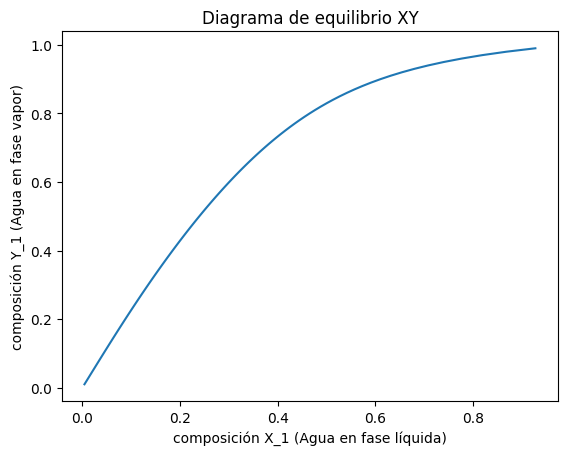

In [70]:
plt.figure
plt.plot(Y_1, VectorX_1)
plt.xlabel('composición X_1 (Agua en fase líquida)')
plt.ylabel('composición Y_1 (Agua en fase vapor)')
plt.title('Diagrama de equilibrio XY')

Text(0.5, 1.0, 'Diagrama de equilibrio XY')

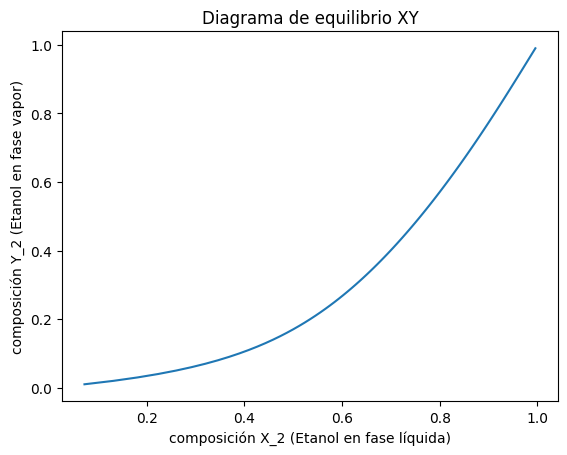

In [71]:
VectorX_2=np.ones(101)-VectorX_1
Y_2=np.ones(101)-Y_1
plt.figure
plt.plot(Y_2, VectorX_2)
plt.xlabel('composición X_2 (Etanol en fase líquida)')
plt.ylabel('composición Y_2 (Etanol en fase vapor)')
plt.title('Diagrama de equilibrio XY')

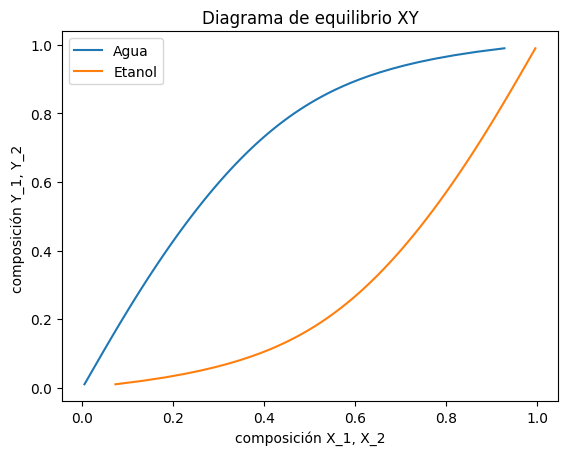

In [72]:
plt.plot(Y_1, VectorX_1)
plt.plot(Y_2, VectorX_2)
plt.xlabel('composición X_1, X_2')
plt.ylabel('composición Y_1, Y_2 ')
plt.title('Diagrama de equilibrio XY')
plt.legend(['Agua', 'Etanol'])